In [11]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants
from sleeprnn.data import utils

In [2]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


In [3]:
subject_id = nsrr.all_ids[0]

In [4]:
subject_id

'ccshs-trec-1800001'

In [5]:
signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)

In [6]:
signal.size

2802000

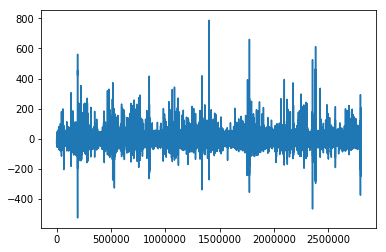

In [7]:
plt.plot(signal)
plt.show()

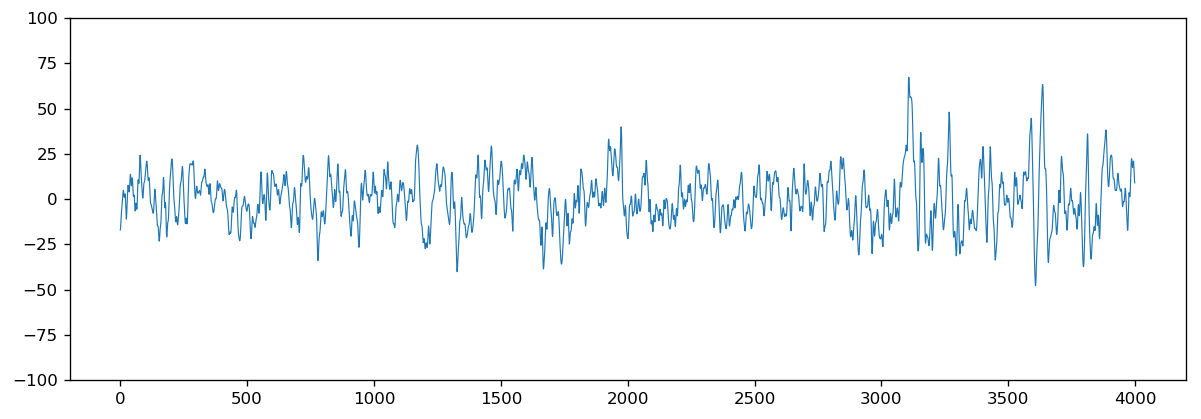

In [10]:
plt.figure(figsize=(12, 4), dpi=120)
plt.plot(signal[100000:104000], linewidth=0.7)
plt.ylim([-100, 100])
plt.show()

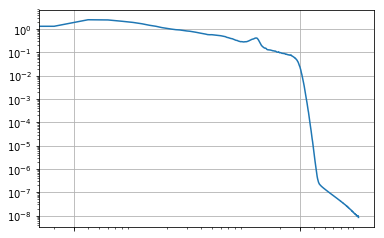

In [19]:
fs = nsrr.fs
f, y = utils.power_spectrum_by_sliding_window(signal, fs)

plt.plot(f, y)
plt.yscale('log')
plt.xscale('log')
plt.xticks([0.3, 30])
plt.grid()
plt.show()

In [20]:
original_fname = os.path.join(nsrr.dataset_dir, 'ccshs', 'register_and_state', '%s.npz' % subject_id)
original_data = np.load(original_fname)
original_signal = original_data['signal']

In [21]:
original_signal.shape

(2802000,)

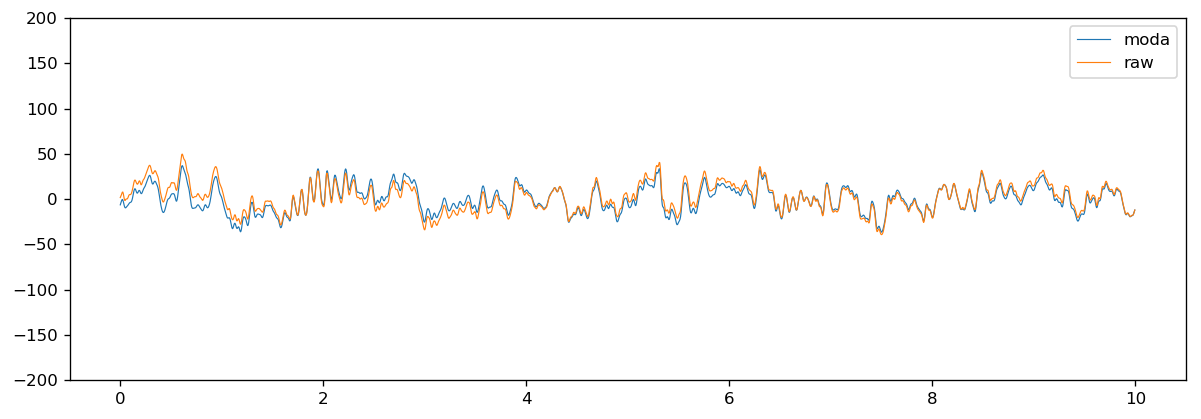

In [27]:
start_sample = 320000
window_size = 2000


time_axis = np.arange(window_size) / fs
plt.figure(figsize=(12, 4), dpi=120)
plt.plot(time_axis, signal[start_sample:start_sample + window_size], linewidth=0.7, label="moda")
plt.plot(time_axis, original_signal[start_sample:start_sample + window_size], linewidth=0.7, label="raw")
plt.ylim([-200, 200])
plt.legend()
plt.show()

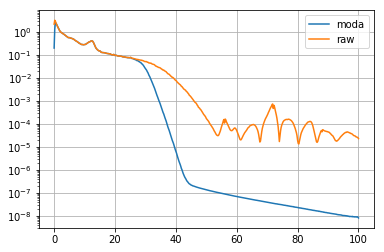

In [31]:
fs = nsrr.fs
f, y = utils.power_spectrum_by_sliding_window(signal, fs)
f, y_original = utils.power_spectrum_by_sliding_window(original_signal, fs)

plt.plot(f, y, label="moda")
plt.plot(f, y_original, label="raw")
plt.yscale('log')
#plt.xscale('log')
plt.legend()
#plt.xticks([0.3, 30])
plt.grid()
plt.show()

In [33]:
subject_data = nsrr.read_subject_data(subject_id)

In [37]:
subject_data['sex']

array('f', dtype='<U1')